In [4]:
import os
import cv2
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from keras import backend as K
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, Reshape, Bidirectional, LSTM, Dense, Lambda, Activation, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam


In [5]:
train = pd.read_csv('written_name_train_v2.csv')
valid = pd.read_csv('written_name_validation_v2.csv')

In [6]:
train

,FILENAME,IDENTITY
0,TRAIN_00001.jpg,BALTHAZAR
1,TRAIN_00002.jpg,SIMON
2,TRAIN_00003.jpg,BENES
3,TRAIN_00004.jpg,LA LOVE
4,TRAIN_00005.jpg,DAPHNE
...,...,...
330956,TRAIN_330957.jpg,LENNY
330957,TRAIN_330958.jpg,TIFFANY
330958,TRAIN_330959.jpg,COUTINHO DESA
330959,TRAIN_330960.jpg,MOURAD


In [7]:
valid

,FILENAME,IDENTITY
0,VALIDATION_0001.jpg,BILEL
1,VALIDATION_0002.jpg,LAUMIONIER
2,VALIDATION_0003.jpg,LEA
3,VALIDATION_0004.jpg,JEAN-ROCH
4,VALIDATION_0005.jpg,RUPP
...,...,...
41365,VALIDATION_41366.jpg,CHAILLAN
41366,VALIDATION_41367.jpg,BAROUH
41367,VALIDATION_41368.jpg,MAXENCE
41368,VALIDATION_41369.jpg,HAMELIN


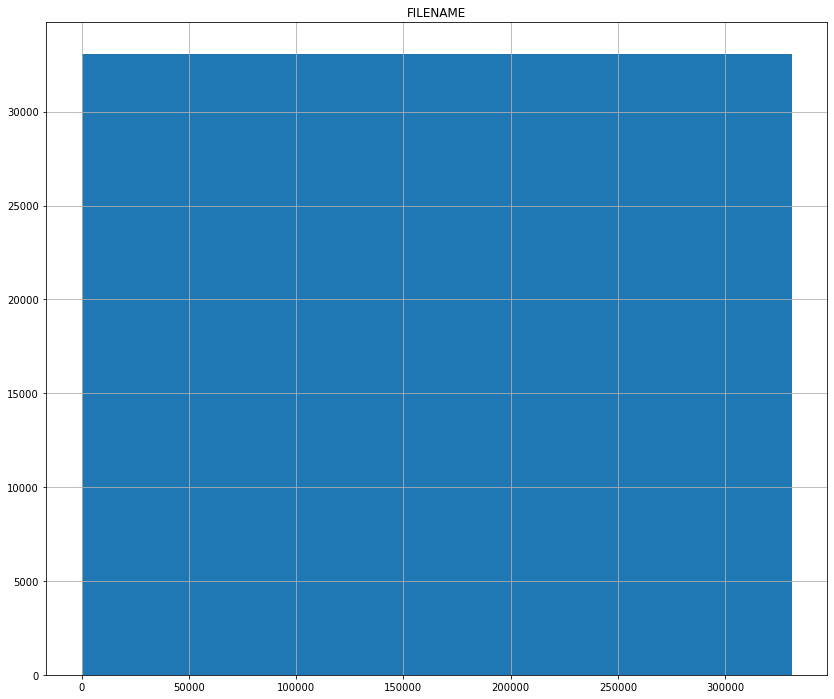

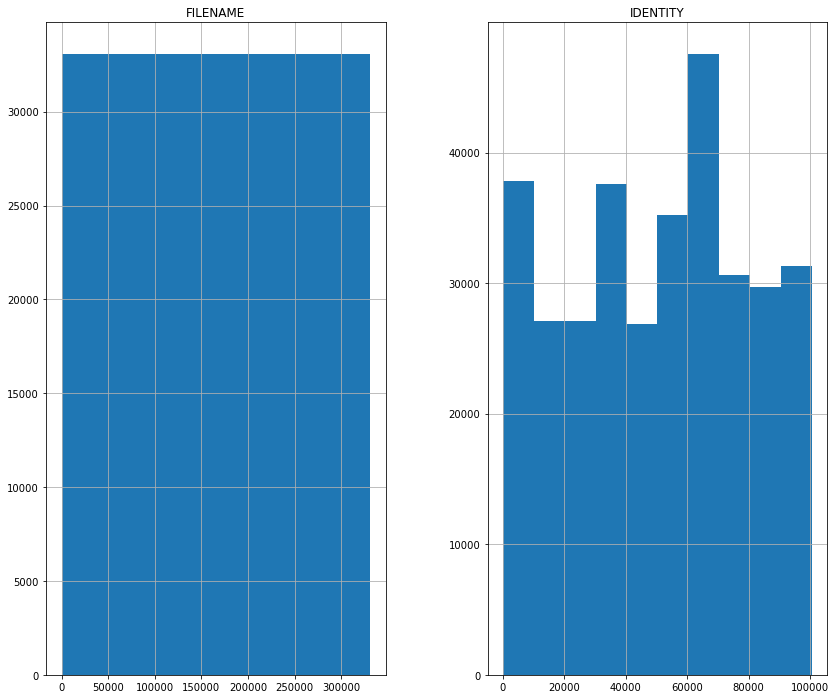

,FILENAME,IDENTITY
FILENAME,1.000000,0.000332
IDENTITY,0.000332,1.000000


In [8]:
list_1=list(train.columns)
list_cate=[]
for i in list_1:
    if train[i].dtype=='object':
        list_cate.append(i)
        from sklearn.preprocessing import LabelEncoder
le=LabelEncoder()
for i in list_cate:
    train[i]=le.fit_transform(train[i])
    train.hist(figsize=(14,12))
plt.show()
train.corr()

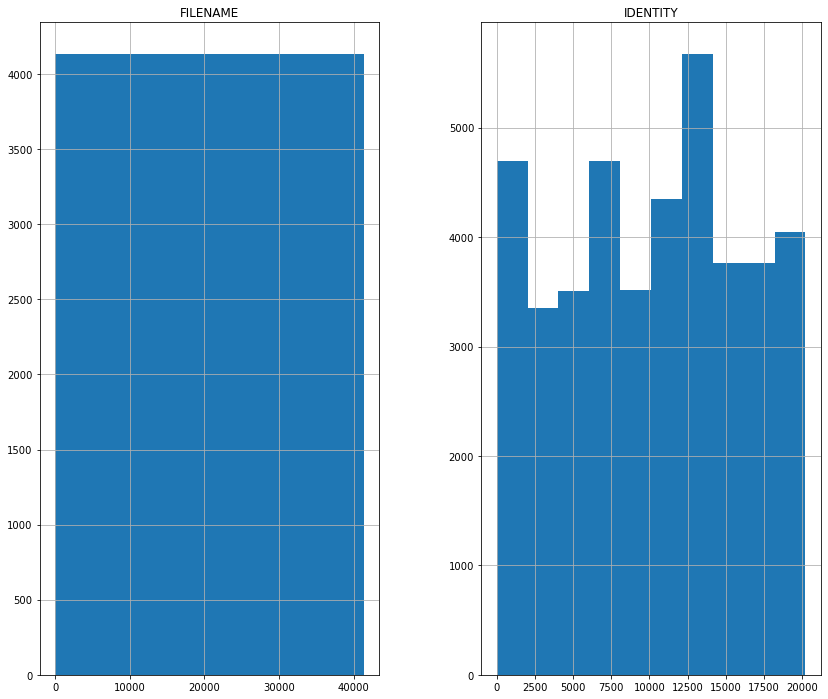

,FILENAME,IDENTITY
FILENAME,1.00000,0.00106
IDENTITY,0.00106,1.00000


In [9]:
list_1=list(valid.columns)
list_cate=[]
for i in list_1:
    if valid[i].dtype=='object':
        list_cate.append(i)
        from sklearn.preprocessing import LabelEncoder
le=LabelEncoder()
for i in list_cate:
    valid[i]=le.fit_transform(valid[i])
valid.hist(figsize=(14,12))
plt.show()
valid.corr()

<AxesSubplot:>

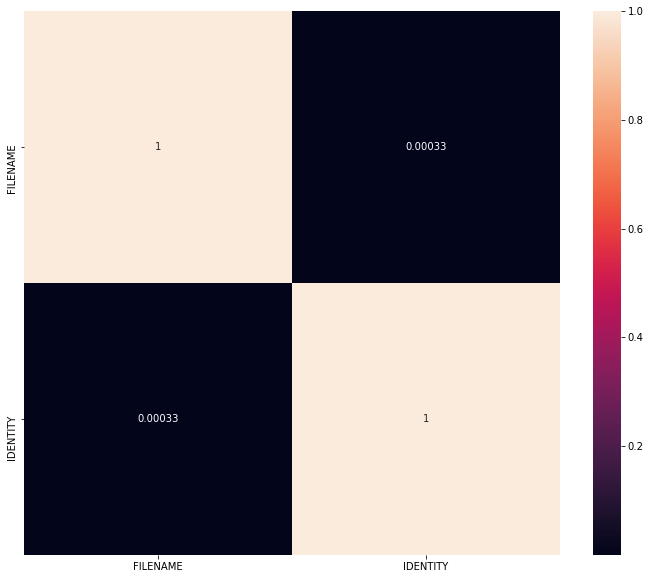

In [10]:
plt.figure(figsize = (12,10))
sns.heatmap(train.corr(), annot =True)


<AxesSubplot:>

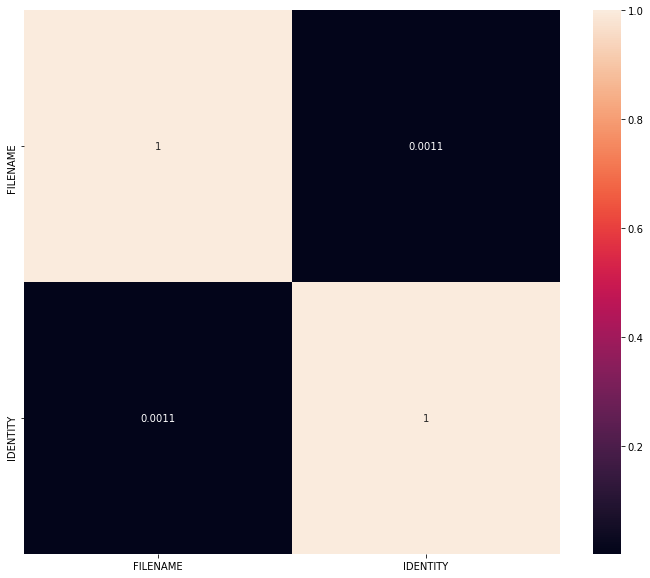

In [11]:
plt.figure(figsize = (12,10))
sns.heatmap(valid.corr(), annot =True)

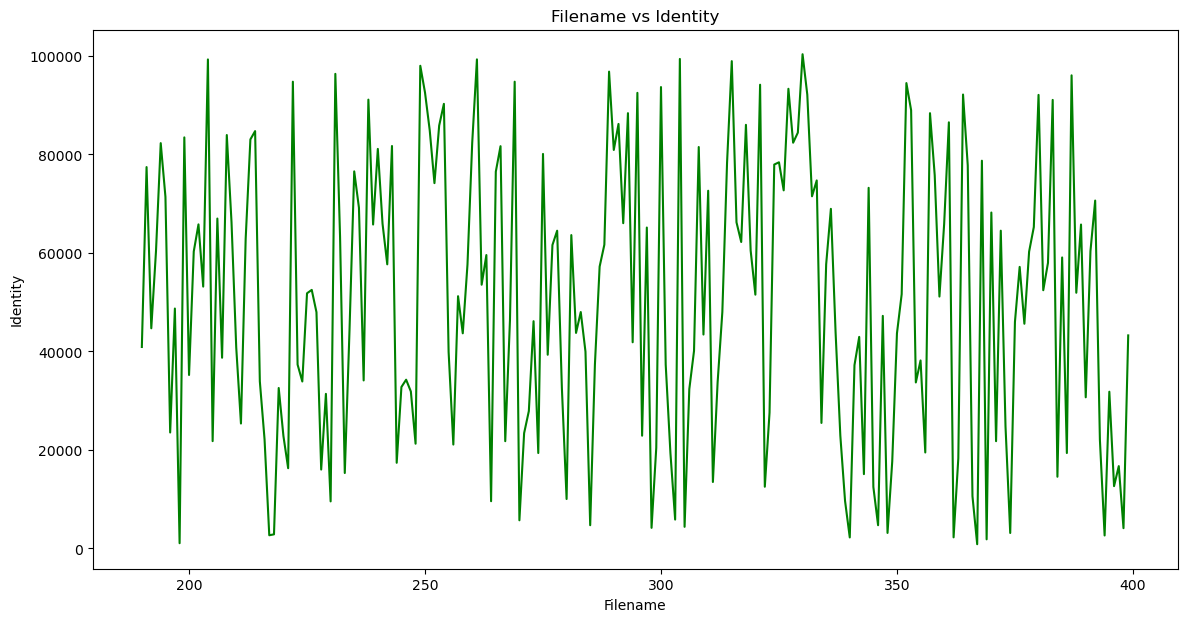

In [12]:
plt.style.use("default")
plt.figure(figsize=(14,7))
sns.lineplot(x = "FILENAME",y = "IDENTITY",data = train[190:400], color='g')
plt.title("Filename vs Identity")
plt.xlabel("Filename")
plt.ylabel("Identity")
plt.show()

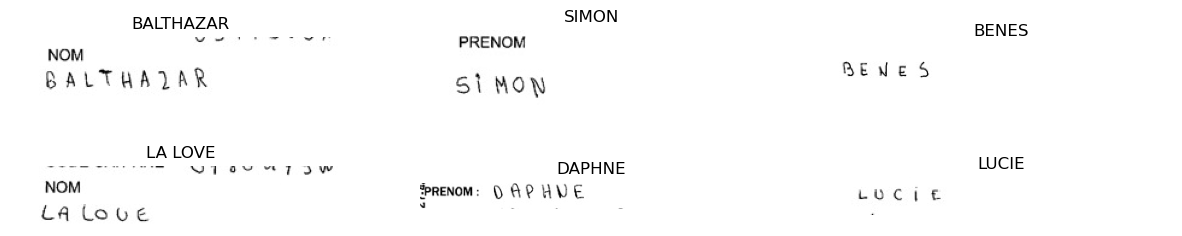

In [15]:
#reshape
train = pd.read_csv('written_name_train_v2.csv')
valid = pd.read_csv('written_name_validation_v2.csv')
plt.figure(figsize=(15, 10))

for i in range(6):
    ax = plt.subplot(2, 3, i+1)
    img_dir = 'train_v2/train/'+train.loc[i, 'FILENAME']
    image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
    plt.imshow(image, cmap = 'gray')
    plt.title(train.loc[i, 'IDENTITY'], fontsize=12)
    plt.axis('off')

plt.subplots_adjust(wspace=0.2, hspace=-0.8)

In [16]:
print("Number of NaNs in train set      : ", train['IDENTITY'].isnull().sum())
print("Number of NaNs in validation set : ", valid['IDENTITY'].isnull().sum())

Number of NaNs in train set      :  565
Number of NaNs in validation set :  78


In [17]:
train.dropna(axis=0, inplace=True)
valid.dropna(axis=0, inplace=True)

In [18]:
print("Number of NaNs in train set      : ", train['IDENTITY'].isnull().sum())
print("Number of NaNs in validation set : ", valid['IDENTITY'].isnull().sum())

Number of NaNs in train set      :  0
Number of NaNs in validation set :  0


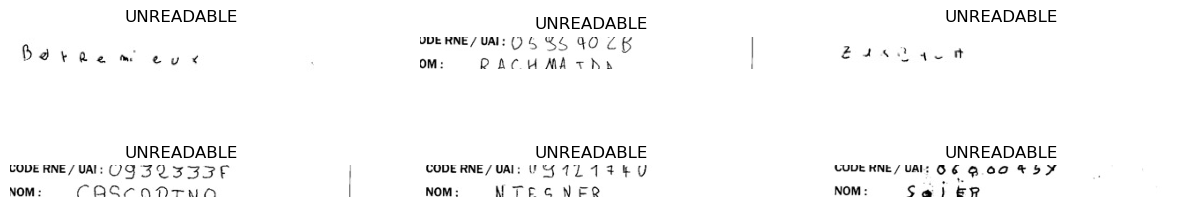

In [20]:
unreadable = train[train['IDENTITY'] == 'UNREADABLE']
unreadable.reset_index(inplace = True, drop=True)

plt.figure(figsize=(15, 10))

for i in range(6):
    ax = plt.subplot(2, 3, i+1)
    img_dir = 'train_v2/train/'+unreadable.loc[i, 'FILENAME']
    image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
    plt.imshow(image, cmap = 'gray')
    plt.title(unreadable.loc[i, 'IDENTITY'], fontsize=12)
    plt.axis('off')

plt.subplots_adjust(wspace=0.2, hspace=-0.8)

In [21]:
train = train[train['IDENTITY'] != 'UNREADABLE']
valid = valid[valid['IDENTITY'] != 'UNREADABLE']

In [22]:
train['IDENTITY'] = train['IDENTITY'].str.upper()
valid['IDENTITY'] = valid['IDENTITY'].str.upper()

In [23]:
train.reset_index(inplace = True, drop=True) 
valid.reset_index(inplace = True, drop=True)

In [24]:
def preprocess(img):
    (h, w) = img.shape
    
    final_img = np.ones([64, 256])*255 # blank white image
    
    # crop
    if w > 256:
        img = img[:, :256]
        
    if h > 64:
        img = img[:64, :]
    
    
    final_img[:h, :w] = img
    return cv2.rotate(final_img, cv2.ROTATE_90_CLOCKWISE)

In [25]:
train_size = 10000
valid_size= 1000

In [26]:
train_x = []

for i in range(train_size):
    img_dir = 'train_v2/train/'+train.loc[i, 'FILENAME']
    image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
    image = preprocess(image)
    image = image/255.
    train_x.append(image)

In [27]:
valid_x = []

for i in range(valid_size):
    img_dir = 'validation_v2/validation/'+valid.loc[i, 'FILENAME']
    image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
    image = preprocess(image)
    image = image/255.
    valid_x.append(image)

In [28]:
train_x = np.array(train_x).reshape(-1, 256, 64, 1)
valid_x = np.array(valid_x).reshape(-1, 256, 64, 1)

In [29]:
alphabets = u"ABCDEFGHIJKLMNOPQRSTUVWXYZ-' "
max_str_len = 24 # max length of input labels
num_of_characters = len(alphabets) + 1 # +1 for ctc pseudo blank
num_of_timestamps = 64 # max length of predicted labels


def label_to_num(label):
    label_num = []
    for ch in label:
        label_num.append(alphabets.find(ch))
        
    return np.array(label_num)

def num_to_label(num):
    ret = ""
    for ch in num:
        if ch == -1:  # CTC Blank
            break
        else:
            ret+=alphabets[ch]
    return ret

In [30]:
name = 'VHIDISHA'
print(name, '\n',label_to_num(name))

VHIDISHA 
 [21  7  8  3  8 18  7  0]


In [31]:
train_y = np.ones([train_size, max_str_len]) * -1
train_label_len = np.zeros([train_size, 1])
train_input_len = np.ones([train_size, 1]) * (num_of_timestamps-2)
train_output = np.zeros([train_size])

for i in range(train_size):
    train_label_len[i] = len(train.loc[i, 'IDENTITY'])
    train_y[i, 0:len(train.loc[i, 'IDENTITY'])]= label_to_num(train.loc[i, 'IDENTITY']) 

In [32]:
valid_y = np.ones([valid_size, max_str_len]) * -1
valid_label_len = np.zeros([valid_size, 1])
valid_input_len = np.ones([valid_size, 1]) * (num_of_timestamps-2)
valid_output = np.zeros([valid_size])

for i in range(valid_size):
    valid_label_len[i] = len(valid.loc[i, 'IDENTITY'])
    valid_y[i, 0:len(valid.loc[i, 'IDENTITY'])]= label_to_num(valid.loc[i, 'IDENTITY'])    
print('True label : ',train.loc[100, 'IDENTITY'] , '\ntrain_y : ',train_y[100],'\ntrain_label_len : ',train_label_len[100], 
      '\ntrain_input_len : ', train_input_len[100])

True label :  NOUR 
train_y :  [13. 14. 20. 17. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1.] 
train_label_len :  [4.] 
train_input_len :  [62.]


In [33]:
# Model
input_data = Input(shape=(256, 64, 1), name='input')

inner = Conv2D(32, (3, 3), padding='same', name='conv1', kernel_initializer='he_normal')(input_data)  
inner = BatchNormalization()(inner)
inner = Activation('relu')(inner)
inner = MaxPooling2D(pool_size=(2, 2), name='max1')(inner)

inner = Conv2D(64, (3, 3), padding='same', name='conv2', kernel_initializer='he_normal')(inner)
inner = BatchNormalization()(inner)
inner = Activation('relu')(inner)
inner = MaxPooling2D(pool_size=(2, 2), name='max2')(inner)
inner = Dropout(0.3)(inner)

inner = Conv2D(128, (3, 3), padding='same', name='conv3', kernel_initializer='he_normal')(inner)
inner = BatchNormalization()(inner)
inner = Activation('relu')(inner)
inner = MaxPooling2D(pool_size=(1, 2), name='max3')(inner)
inner = Dropout(0.3)(inner)

# CNN to RNN
inner = Reshape(target_shape=((64, 1024)), name='reshape')(inner)
inner = Dense(64, activation='relu', kernel_initializer='he_normal', name='dense1')(inner)

## RNN
inner = Bidirectional(LSTM(256, return_sequences=True), name = 'lstm1')(inner)
inner = Bidirectional(LSTM(256, return_sequences=True), name = 'lstm2')(inner)

## OUTPUT
inner = Dense(num_of_characters, kernel_initializer='he_normal',name='dense2')(inner)
y_pred = Activation('softmax', name='softmax')(inner)

model = Model(inputs=input_data, outputs=y_pred)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 256, 64, 1)]      0         
_________________________________________________________________
conv1 (Conv2D)               (None, 256, 64, 32)       320       
_________________________________________________________________
batch_normalization (BatchNo (None, 256, 64, 32)       128       
_________________________________________________________________
activation (Activation)      (None, 256, 64, 32)       0         
_________________________________________________________________
max1 (MaxPooling2D)          (None, 128, 32, 32)       0         
_________________________________________________________________
conv2 (Conv2D)               (None, 128, 32, 64)       18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 128, 32, 64)       256   

In [43]:
# the ctc loss function
def ctc_lambda_func(args):
    y_pred, labels, input_length, label_length = args
    # the 2 is critical here since the first couple outputs of the RNN
    # tend to be garbage
    y_pred = y_pred[:, 2:, :]
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)
labels = Input(name='gtruth_labels', shape=[max_str_len], dtype='float32')
input_length = Input(name='input_length', shape=[1], dtype='int64')
label_length = Input(name='label_length', shape=[1], dtype='int64')

ctc_loss = Lambda(ctc_lambda_func, output_shape=(1,), name='ctc')([y_pred, labels, input_length, label_length])
model_final = Model(inputs=[input_data, labels, input_length, label_length], outputs=ctc_loss)
# the loss calculation occurs elsewhere, so we use a dummy lambda function for the loss
model_final.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer=Adam(lr = 0.0001), metrics=['accuracy'])
history=model_final.fit(x=[train_x, train_y, train_input_len, train_label_len], y=train_output, 
                validation_data=([valid_x, valid_y, valid_input_len, valid_label_len], valid_output),
                epochs=10, batch_size=250)

Epoch 1/10
40/40 [==============================] - 372s 9s/step - loss: 1.7047 - accuracy: 0.4821 - val_loss: 3.3704 - val_accuracy: 0.4530
Epoch 2/10
40/40 [==============================] - 409s 10s/step - loss: 1.6237 - accuracy: 0.4997 - val_loss: 3.4209 - val_accuracy: 0.4410
Epoch 3/10
40/40 [==============================] - 616s 15s/step - loss: 1.5682 - accuracy: 0.5044 - val_loss: 3.3615 - val_accuracy: 0.4630
Epoch 4/10
40/40 [==============================] - 617s 15s/step - loss: 1.5517 - accuracy: 0.5089 - val_loss: 3.4509 - val_accuracy: 0.4490
Epoch 5/10
40/40 [==============================] - 608s 15s/step - loss: 1.5296 - accuracy: 0.5187 - val_loss: 3.5558 - val_accuracy: 0.4120
Epoch 6/10
40/40 [==============================] - 778s 20s/step - loss: 1.4980 - accuracy: 0.5205 - val_loss: 3.5077 - val_accuracy: 0.4440
Epoch 7/10
40/40 [==============================] - 2958s 75s/step - loss: 1.4715 - accuracy: 0.5287 - val_loss: 3.5465 - val_accuracy: 0.4410
Epoch 

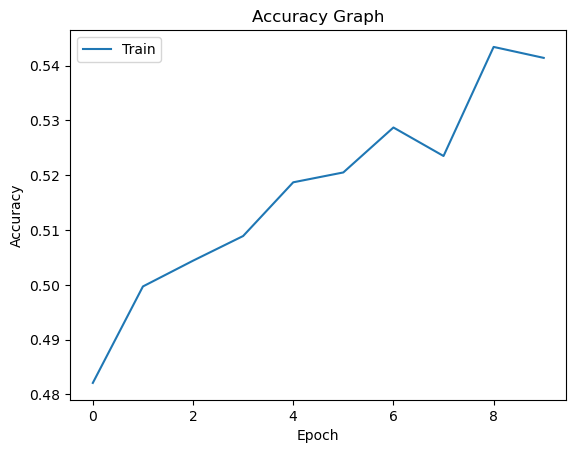

In [46]:
plt.plot(history.history['accuracy'])
plt.title('Accuracy Graph')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

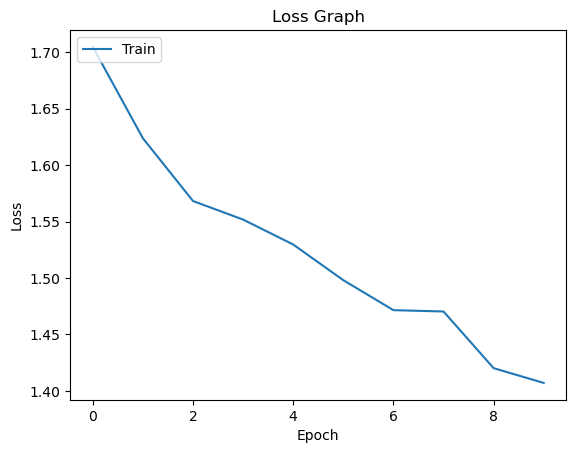

In [47]:
plt.plot(history.history['loss'])
plt.title('Loss Graph')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [48]:
preds = model.predict(valid_x)
decoded = K.get_value(K.ctc_decode(preds, input_length=np.ones(preds.shape[0])*preds.shape[1], 
                                   greedy=True)[0][0])

prediction = []
for i in range(valid_size):
    prediction.append(num_to_label(decoded[i]))

In [49]:
y_true = valid.loc[0:valid_size, 'IDENTITY']
correct_char = 0
total_char = 0
correct = 0

for i in range(valid_size):
    pr = prediction[i]
    tr = y_true[i]
    total_char += len(tr)
    
    for j in range(min(len(tr), len(pr))):
        if tr[j] == pr[j]:
            correct_char += 1
            
    if pr == tr :
        correct += 1 
    
print('Correct characters predicted : %.2f%%' %(correct_char*100/total_char))
print('Correct words predicted      : %.2f%%' %(correct*100/valid_size))

Correct characters predicted : 69.76%
Correct words predicted      : 51.90%


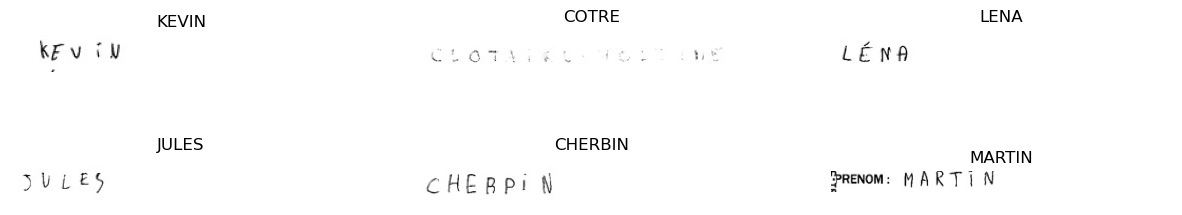

In [50]:
#final testing
test = pd.read_csv('written_name_test_v2.csv')

plt.figure(figsize=(15, 10))
for i in range(6):
    ax = plt.subplot(2, 3, i+1)
    img_dir = 'test_v2/test/'+test.loc[i, 'FILENAME']
    image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
    plt.imshow(image, cmap='gray')
    
    image = preprocess(image)
    image = image/255.
    pred = model.predict(image.reshape(1, 256, 64, 1))
    decoded = K.get_value(K.ctc_decode(pred, input_length=np.ones(pred.shape[0])*pred.shape[1], 
                                       greedy=True)[0][0])
    plt.title(num_to_label(decoded[0]), fontsize=12)
    plt.axis('off')
    
plt.subplots_adjust(wspace=0.2, hspace=-0.8)

In [51]:
print(decoded[0])

[12  0 17 19  8 13 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
